In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

np.random.seed(7)



## 1) The Historical Perceptron (Rosenblatt, 1957)

A single neuron that computes a weighted sum of inputs and applies a **step** activation:

$$ y = \begin{cases} 1, & \mathbf{w}^\top \mathbf{x} + b \ge 0 \\ 0, & \text{otherwise} \end{cases} $$

**Learning rule:**
- If prediction is wrong, nudge weights toward the correct class:
$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \,(y - \hat{y})\, \mathbf{x} $$
$$ b \leftarrow b + \eta \, (y - \hat{y}) $$

Works for **linearly separable** data, fails for **XOR**-type patterns.


In [2]:
# Linearly separable toy dataset
X, y = make_classification(n_samples=400, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=1, class_sep=2.0, random_state=7)

In [3]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

In [4]:
clf = Perceptron(max_iter=1000, eta0=0.1, random_state=7, tol=1e-5)
clf.fit(Xtr, ytr)
pred = clf.predict(Xte)
acc = accuracy_score(yte, pred)
print(f"Perceptron accuracy on linearly separable data: {acc:.3f}")

Perceptron accuracy on linearly separable data: 0.983


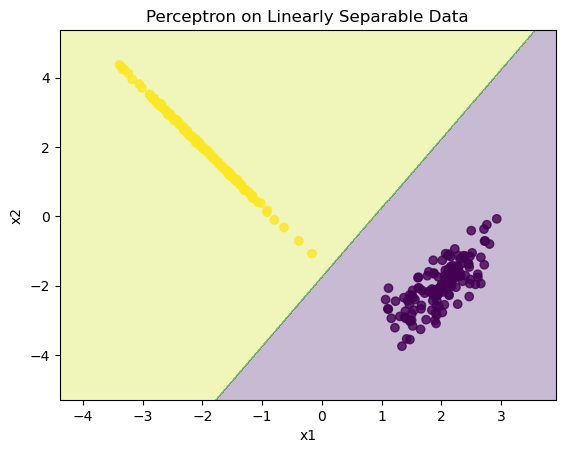

In [5]:
# Plot decision boundary (single plot only)
h = 0.02
x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(Xtr[:,0], Xtr[:,1], c=ytr, alpha=0.8)
plt.title("Perceptron on Linearly Separable Data")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()


In [6]:
# Nonlinear pattern (moons) — perceptron will struggle
Xm, ym = make_moons(n_samples=400, noise=0.2, random_state=7)

In [7]:
Xm_tr, Xm_te, ym_tr, ym_te = train_test_split(Xm, ym, test_size=0.3, random_state=7, stratify=ym)

In [8]:
p_moon = Perceptron(max_iter=2000, eta0=0.1, random_state=7, tol=1e-5)
p_moon.fit(Xm_tr, ym_tr)
predm = p_moon.predict(Xm_te)
accm = accuracy_score(ym_te, predm)
print(f"Perceptron accuracy on nonlinearly separable data (moons): {accm:.3f}")

Perceptron accuracy on nonlinearly separable data (moons): 0.742


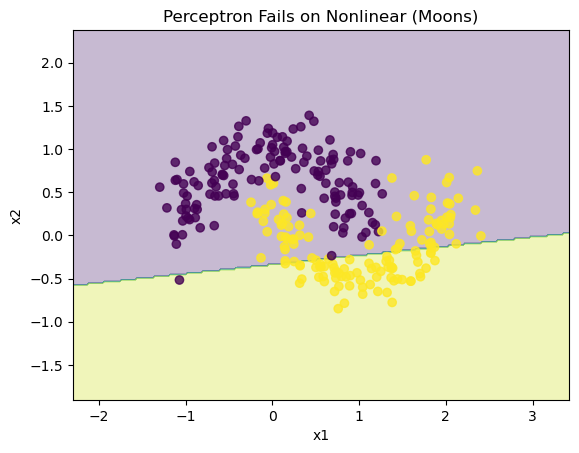

In [9]:
# Plot decision boundary
h = 0.02
x_min, x_max = Xm[:,0].min()-1, Xm[:,0].max()+1
y_min, y_max = Xm[:,1].min()-1, Xm[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = p_moon.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(Xm_tr[:,0], Xm_tr[:,1], c=ym_tr, alpha=0.8)
plt.title("Perceptron Fails on Nonlinear (Moons)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()



## 2) Core Activation Functions

**Sigmoid**: $$ \sigma(x) = \frac{1}{1 + e^{-x}} $$ — squashes to (0,1).  
**Tanh**: $$ \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} $$ — squashes to (-1,1).  
**ReLU**: $$ \text{ReLU}(x) = \max(0, x) $$ — piecewise linear, non-saturating for \(x>0\).  
**Softmax (vector)**: $$ \mathrm{softmax}(\mathbf{z})_i = \frac{e^{z_i}}{\sum_j e^{z_j}} $$ — turns scores into a probability simplex for multi-class.

Below we plot each activation and its derivative to see how gradients behave.


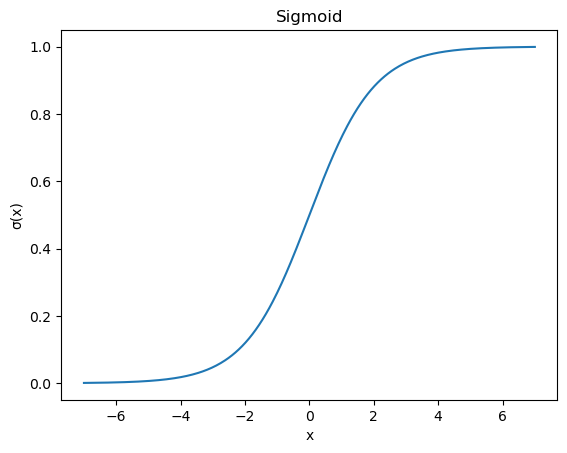

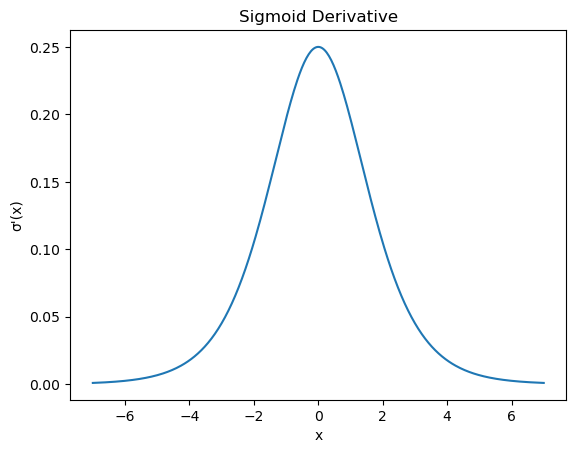

In [10]:
# Plot functions (one figure per chart, as requested)
xs = np.linspace(-7, 7, 400)

# Define activations and derivatives
def sigmoid(x):
    return 1/(1+np.exp(-x))

def dsigmoid(x):
    s = sigmoid(x)
    return s*(1-s)
# # Sigmoid
plt.figure()
plt.plot(xs, sigmoid(xs))
plt.title("Sigmoid")
plt.xlabel("x"); plt.ylabel("σ(x)")
plt.show()

plt.figure()
plt.plot(xs, dsigmoid(xs))
plt.title("Sigmoid Derivative")
plt.xlabel("x"); plt.ylabel("σ'(x)")
plt.show()

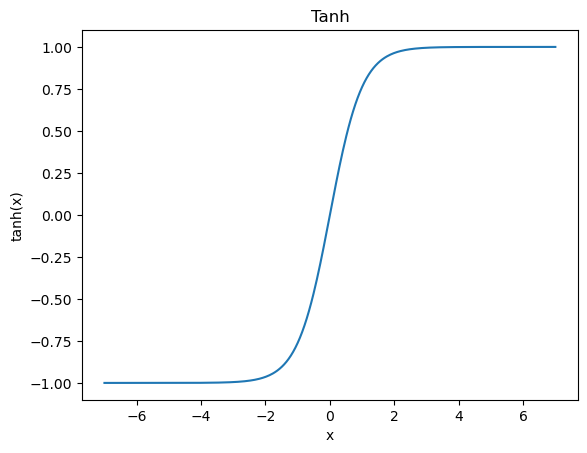

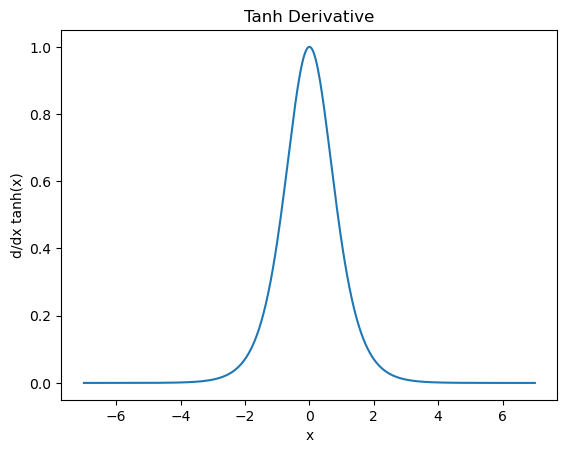

In [11]:
def tanh(x):
    return np.tanh(x)

def dtanh(x):
    t = np.tanh(x)
    return 1 - t**2

# Tanh
plt.figure()
plt.plot(xs, tanh(xs))
plt.title("Tanh")
plt.xlabel("x"); plt.ylabel("tanh(x)")
plt.show()

plt.figure()
plt.plot(xs, dtanh(xs))
plt.title("Tanh Derivative")
plt.xlabel("x"); plt.ylabel("d/dx tanh(x)")
plt.show()


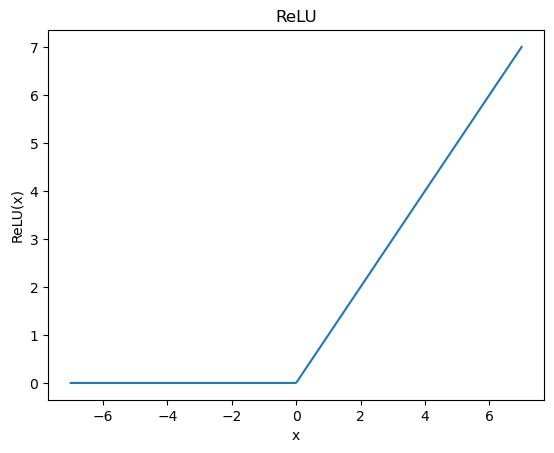

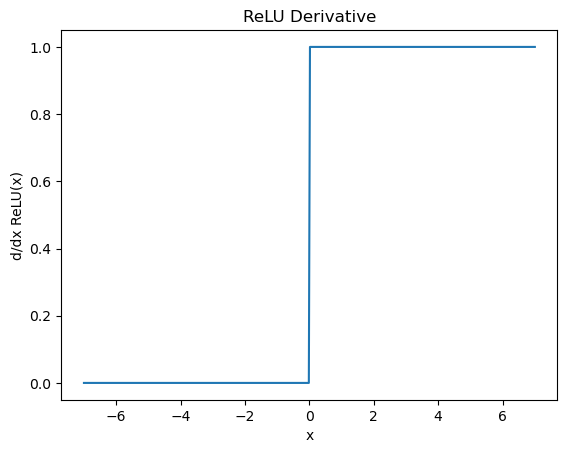

In [12]:
def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return (x>0).astype(float)

# ReLU
plt.figure()
plt.plot(xs, relu(xs))
plt.title("ReLU")
plt.xlabel("x"); plt.ylabel("ReLU(x)")
plt.show()

plt.figure()
plt.plot(xs, drelu(xs))
plt.title("ReLU Derivative")
plt.xlabel("x"); plt.ylabel("d/dx ReLU(x)")
plt.show()



## 3) Vanishing Gradient (and why ReLU helps)

Sigmoid and tanh **saturate** for large |x|: their derivatives shrink toward 0.  
In deep nets, repeated multiplication of small derivatives makes gradients **vanish**, slowing or stalling learning.

Below, we simulate gradient magnitudes across layers assuming pre-activations are roughly Gaussian.


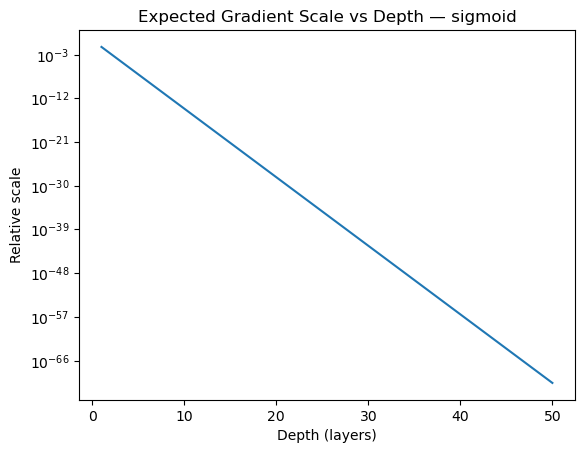

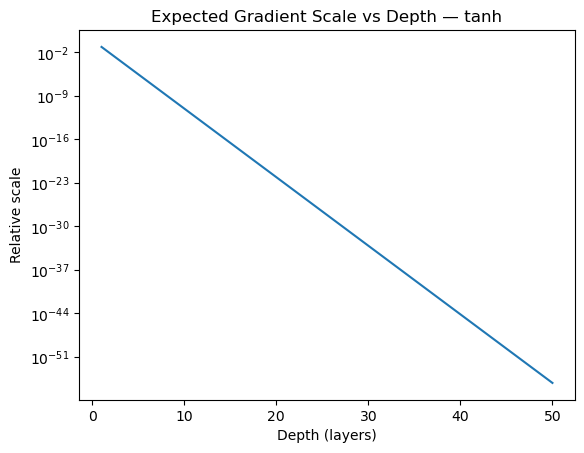

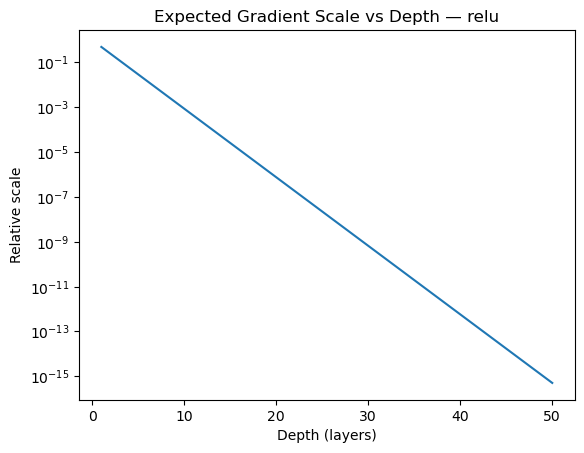

In [13]:
# Simulate gradient shrinkage across depth for different activations
rng = np.random.default_rng(7)


def expected_grad_scale(activation, samples=20000):
  # for each activation:
    if activation == "relu":
      z = np.random.normal(0, np.sqrt(16), samples)  # He initialization
      g = drelu(z)
    elif activation == "sigmoid":
        z = np.random.normal(0, 10, samples)  # Xavier for tanh/sigmoid
        g = dsigmoid(z)
    elif activation == "tanh":
        z = np.random.normal(0, 10, samples)  # Xavier for tanh/sigmoid
        g = dtanh(z)
    else:
        raise ValueError("unknown activation")
    return np.mean(np.abs(g))

depths = np.arange(1, 51)
scales = {a: [] for a in ["sigmoid", "tanh", "relu"]}

base = {a: expected_grad_scale(a) for a in scales}
for d in depths:
    for a in scales:
        scales[a].append(base[a]**d)

for a in scales:
    plt.figure()
    plt.plot(depths, scales[a])
    plt.title(f"Expected Gradient Scale vs Depth — {a}")
    plt.xlabel("Depth (layers)"); plt.ylabel("Relative scale")
    plt.yscale("log")
    plt.show()



## 4) How Activations Shape Decision Surfaces

We'll train shallow MLPs with different activations on 2D datasets and visualize the learned decision regions.


In [ ]:
def plot_decision_surface(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:,0].min() - 1.0, X[:,0].max() + 1.0
    y_min, y_max = X[:,1].min() - 1.0, X[:,1].max() + 1.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, alpha=0.8)
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()

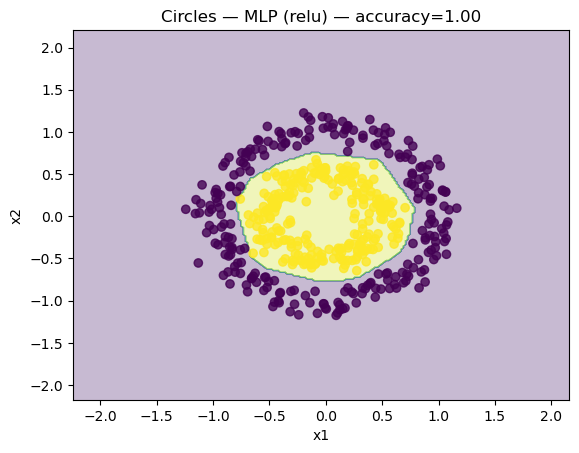

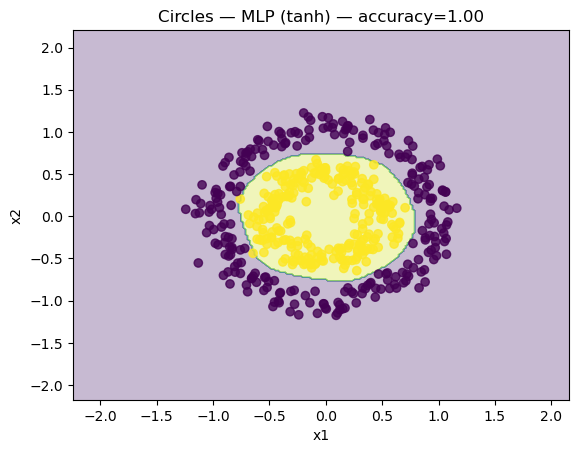

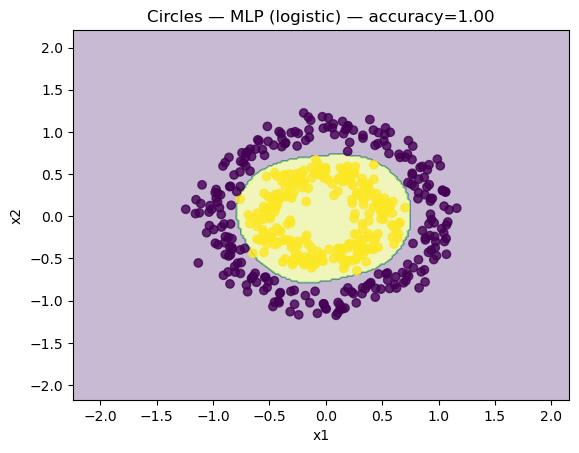

In [15]:
datasets = {
    "Circles": make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=2),
 }
for name, (Xd, yd) in datasets.items():
    n_classes = len(np.unique(yd))
    for act in ["relu", "tanh", "logistic"]:
        clf = MLPClassifier(hidden_layer_sizes=(16,16), activation=act,
                            learning_rate_init=0.05, max_iter=1000, random_state=7)
        clf.fit(Xd, yd)
        acc = clf.score(Xd, yd)
        plot_decision_surface(clf, Xd, yd, f"{name} — MLP ({act}) — accuracy={acc:.2f}")


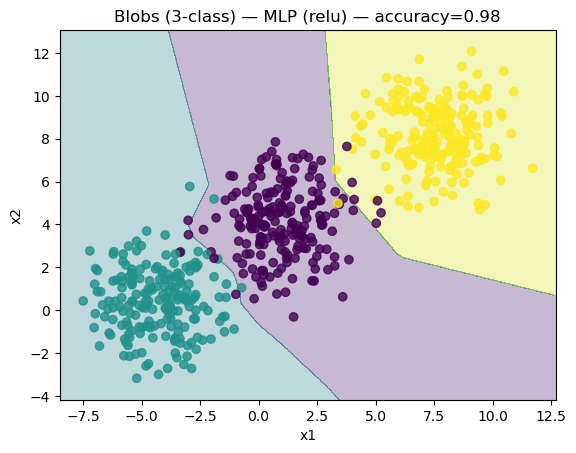

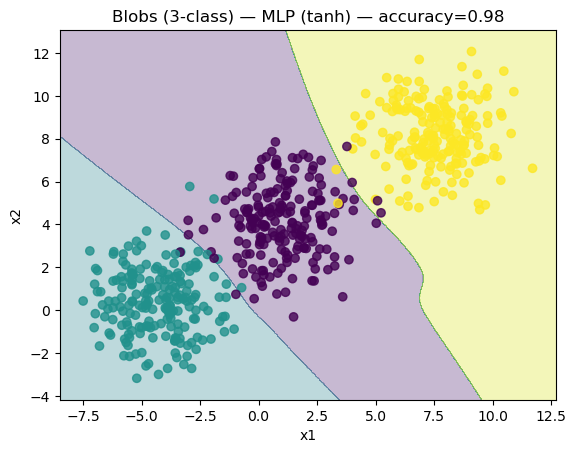

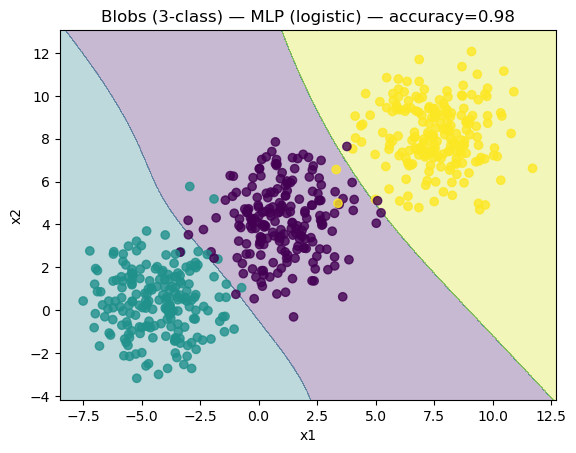

In [16]:
datasets = {
    "Blobs (3-class)": make_blobs(n_samples=600, centers=3, cluster_std=1.5, n_features=2, random_state=3)
}
# For 3-class blobs, adapt output layer automatically
for name, (Xd, yd) in datasets.items():
    n_classes = len(np.unique(yd))
    for act in ["relu", "tanh", "logistic"]:
        clf = MLPClassifier(hidden_layer_sizes=(16,16), activation=act,
                            learning_rate_init=0.05, max_iter=1000, random_state=7)
        clf.fit(Xd, yd)
        acc = clf.score(Xd, yd)
        plot_decision_surface(clf, Xd, yd, f"{name} — MLP ({act}) — accuracy={acc:.2f}")


Note: Though sigmoid is binary classifer, we are using it here because sigmoid is used here for the hidden layers of MLPClassifier.
The output layer is automatically chosen based on the task and
If the target has > 2 classes, MLPClassifier uses softmax activation and cross-entropy loss.

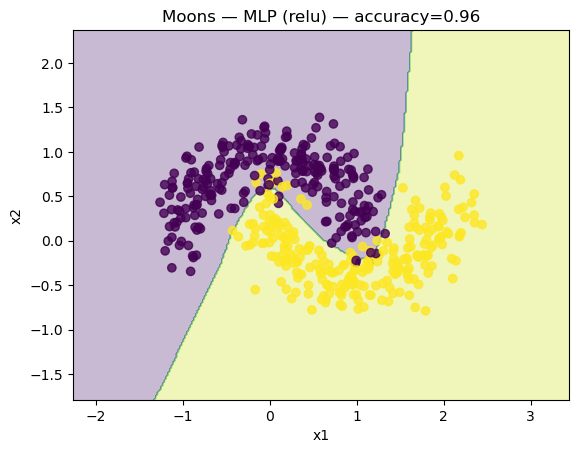

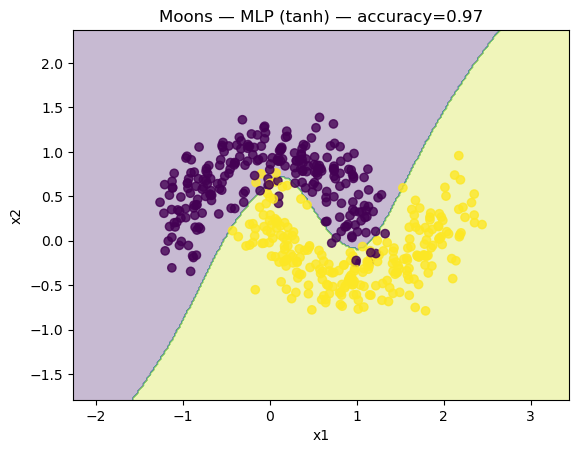

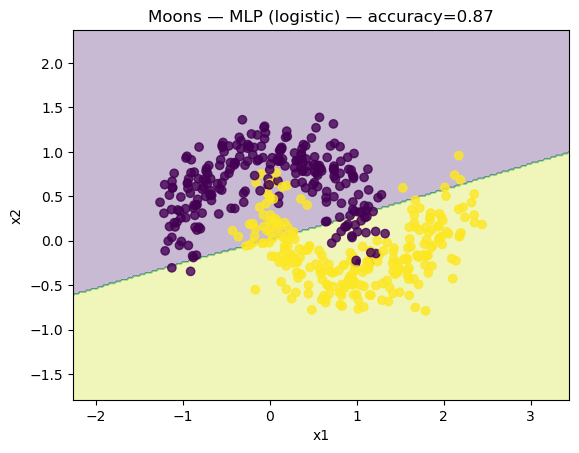

In [17]:
datasets= {"Moons": make_moons(n_samples=500, noise=0.2, random_state=2)}

for name, (Xd, yd) in datasets.items():
    n_classes = len(np.unique(yd))
    for act in ["relu", "tanh", "logistic"]:
        clf = MLPClassifier(hidden_layer_sizes=(16,16), activation=act,
                            learning_rate_init=0.05, max_iter=1000, random_state=7)
        clf.fit(Xd, yd)
        acc = clf.score(Xd, yd)
        plot_decision_surface(clf, Xd, yd, f"{name} — MLP ({act}) — accuracy={acc:.2f}")



## 5) When to Use What (Quick Guide)

- **ReLU** (default for hidden layers): simple, fast, mitigates vanishing gradient for \(x>0\). Try **LeakyReLU/ELU/GELU** if many dead units.
- **Tanh**: zero-centered outputs; good for small networks or when inputs roughly in \([-1,1]\). May suffer vanishing gradients.
- **Sigmoid**: best for **output** of binary classification (with BCE loss). Avoid in deep hidden layers.
- **Softmax**: use at the **output** for multi-class classification with cross-entropy.
- Always pair with good **initialization** (He for ReLU, Xavier/Glorot for tanh/sigmoid) and **normalization** (BatchNorm/LayerNorm) to stabilize training.
